In [ ]:
!pip install tensorflow tensorflow_datasets matplotlib

# Data Preparation

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load the PASCAL VOC 2012 dataset
dataset, info = tfds.load('voc/2012', with_info=True, as_supervised=True)

# Define the training and validation splits
train_dataset = dataset['train'].map(lambda x, y: (tf.image.resize(x, (224, 224)), tf.image.resize(y['segmentation'], (224, 224))))
val_dataset = dataset['validation'].map(lambda x, y: (tf.image.resize(x, (224, 224)), tf.image.resize(y['segmentation'], (224, 224))))

# Normalize the images
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)
    return image, label

train_dataset = train_dataset.map(normalize_image).batch(8).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(normalize_image).batch(8).prefetch(tf.data.experimental.AUTOTUNE)

# Model Architecture

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, concatenate
from tensorflow.keras.models import Model

def create_fcn_model(input_shape=(224, 224, 3), num_classes=21):
    # Load the VGG16 model pre-trained on ImageNet without the fully connected layers
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Get the output of the last convolutional block
    c5 = vgg16.get_layer("block5_conv3").output

    # Define the upsampling path
    up6 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding="same")(c5)
    up6 = concatenate([up6, vgg16.get_layer("block4_conv3").output], axis=3)

    up7 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same")(up6)
    up7 = concatenate([up7, vgg16.get_layer("block3_conv3").output], axis=3)

    up8 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(up7)
    up8 = concatenate([up8, vgg16.get_layer("block2_conv2").output], axis=3)

    up9 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(up8)
    up9 = concatenate([up9, vgg16.get_layer("block1_conv2").output], axis=3)

    # Final upsampling layer to match the input size
    up10 = Conv2DTranspose(num_classes, (3, 3), strides=(2, 2), padding="same")(up9)
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(up10)

    # Create the model
    model = Model(inputs=vgg16.input, outputs=outputs)

    return model

# Instantiate the model
fcn_model = create_fcn_model()

In [16]:
fcn_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [7]:
#pip install visualkeras tensorflow
!pip install visualkeras
import visualkeras

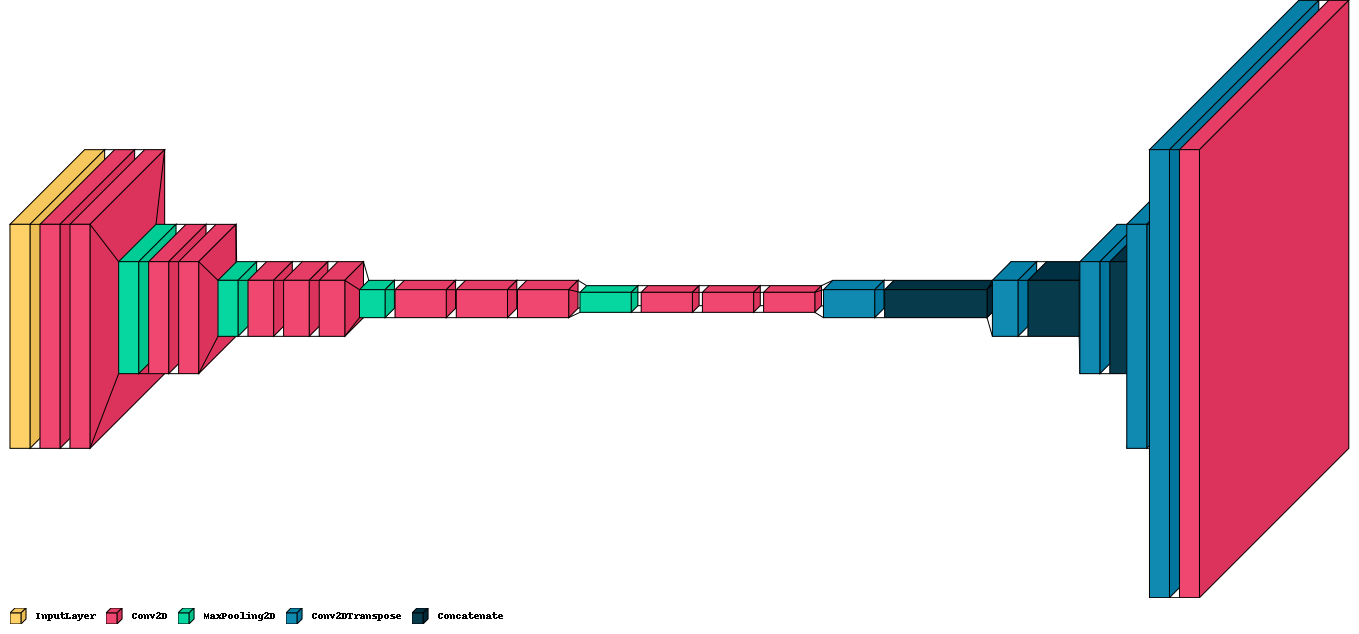

In [15]:
visualkeras.layered_view(fcn_model, scale_xy=1, legend=True)

# Model Training

In [ ]:
fcn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train the model
history = fcn_model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=25)


In [ ]:
# Evaluate the model
val_loss, val_accuracy = fcn_model.evaluate(val_dataset)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


# Model Evaluation

In [ ]:
import numpy as np

def calculate_iou(y_true, y_pred, num_classes=21):
    iou_list = []
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    for cls in range(num_classes):
        intersection = np.sum((y_true == cls) & (y_pred == cls))
        union = np.sum((y_true == cls) | (y_pred == cls))
        if union == 0:
            iou = float('nan')  # If there is no ground truth, do not include in evaluation
        else:
            iou = intersection / union
        iou_list.append(iou)
    return np.nanmean(iou_list)

# Make predictions and calculate IoU
iou_scores = []
for images, labels in val_dataset:
    preds = fcn_model.predict(images)
    preds = np.argmax(preds, axis=-1)
    for i in range(len(labels)):
        iou = calculate_iou(labels[i].numpy(), preds[i], num_classes=21)
        iou_scores.append(iou)

mean_iou = np.mean(iou_scores)
print(f'Mean IoU: {mean_iou}')